### Bibliotecas necessárias 

In [4]:
import pandas
import numpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

### Lendo o arquivo 

In [64]:
data = pandas.read_excel("all_1nm_data.xls", header=0, skiprows=3)
#data
coluna_D = numpy.nan_to_num(data[data.columns[3]])
coluna_F = numpy.nan_to_num(data[data.columns[5]])
coluna_G = numpy.nan_to_num(data[data.columns[6]])
coluna_H = numpy.nan_to_num(data[data.columns[7]])

## Analisando os dados e extraindo de forma mais limpa e otimizada, com o numpy

### Iluminantes

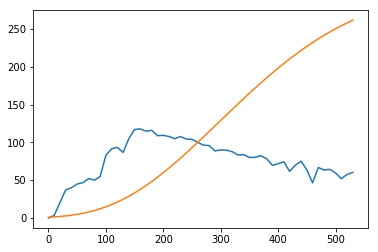

In [7]:
lights = data[data.columns[1:3]]
light_D65 = numpy.nan_to_num(numpy.array(lights[lights.columns[1]]))
light_A = numpy.nan_to_num(numpy.array(lights[lights.columns[0]]))
plt.plot(light_D65)
plt.plot(light_A)
plt.show()

### Betas, "Materiais", eu usei o Vm para testar, pois tinha as propriedades necessárias para ser considerado um beta válido: imagem em [0,1] e dominio em [380,780]. O que gerou um sRGB negativo (fora do espectro visível)

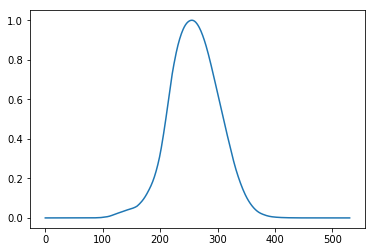

In [8]:
mats = data[data.columns[3:5]]
mat = numpy.nan_to_num(numpy.array(mats[mats.columns[0]]))
plt.plot(mat)
plt.show()

### Referenciais CIE

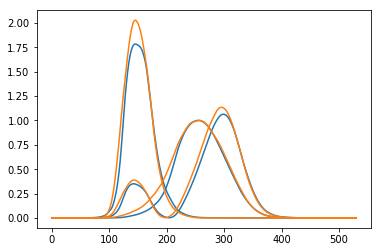

In [9]:
def ref_clean(x,i):
    return numpy.nan_to_num( numpy.array(x[x.columns[i]]))

refs = [ data[data.columns[5:8] ], data[data.columns[8:12]] ]


ref_2 = [ref_clean(refs[0],0),ref_clean(refs[0],1),ref_clean(refs[0],2)]

ref_10 = [ref_clean(refs[1],0),ref_clean(refs[1],1),ref_clean(refs[1],2)]

plt.plot(ref_2[0],'C0')
plt.plot(ref_2[1],'C0')
plt.plot(ref_2[2],'C0')
plt.plot(ref_10[0],'C1')
plt.plot(ref_10[1],'C1')
plt.plot(ref_10[2],'C1')
plt.show()

### Função que converte um spectro para XYZ recebendo um iluminante e um referencial

In [10]:
def CIEXYZ(beta,L,CIE,debug=False): 
    refl = beta*L
    px = refl*CIE[0]
    py = refl*CIE[1]
    pz = refl*CIE[2]
    yl = L*CIE[1]
    k = 1./numpy.sum(yl)
    p = [numpy.sum(px)*k,numpy.sum(py)*k,numpy.sum(pz)*k]
    if debug:
        fig = plt.figure(figsize=(12, 16))
        ax1 = fig.add_subplot(411)
        ax2 = fig.add_subplot(412)
        ax3 = fig.add_subplot(413)
        ax4 = fig.add_subplot(414)
        
        ax1.title.set_text('reflexão = beta * iluminante, constante a todos')
        ax1.plot(refl)
        
        ax2.title.set_text('percepcao em x em relacao à referencia de x')
        ax2.plot(px)
        ax2.legend('percepcao',loc=3)
        ax2.plot(CIE[0])
        ax2.legend('referencia')
       
        ax3.title.set_text('percepcao em y em relacao à referencia de y')
        ax3.plot(py)
        ax3.plot(CIE[1])
        
        ax4.title.set_text('percepcao em z em relacao à referencia de z')
        ax4.plot(pz)
        ax4.plot(CIE[2])
        
        plt.show()
        
    
    return p

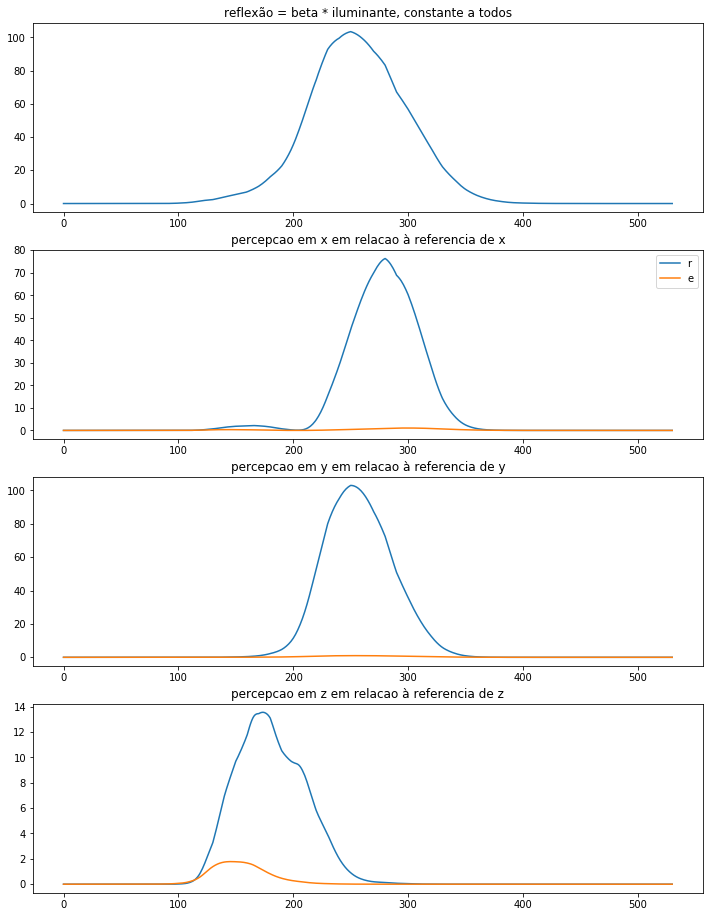

In [11]:
xyz = CIEXYZ(mat,light_D65,ref_2,True)
#xyz = [0.6049185566818934, 0.7134076099404171, 0.14287433425362352]

### Função que calcula o branco em XYZ de um iluminante

In [12]:
def WhiteXYZ(L,CIE): 
    px = L*CIE[0]
    py = L*CIE[1]
    pz = L*CIE[2]
    k = numpy.sum(py)
    p = [numpy.sum(px)/k,1.0,numpy.sum(pz)/k]
    return p

In [13]:
#D65 =  [0.95043, 1, 1.08890]
white = WhiteXYZ(light_D65,ref_2)
white

[0.950470558654283, 1.0, 1.0888287363958846]

### Função que converte XYZ em xyY 

In [14]:
def CIExyY(xyz,light,ref):
    if not numpy.any(xyz):# xyz == [0,0,0]
        py = White(light,ref)[1]
    else:    
        py = xyz[1]
    px = xyz[0]
    pz = xyz[2]
    tot = px+py+pz
    p = [px/tot,py/tot,py]
    return p

In [15]:
CIExyY(xyz,light_D65,ref_2)

[0.3818617684094465, 0.545805384271693, 0.7273855602265707]

### Função que converte XYZ em Lab

In [16]:
def cube(x):
    if 0<=x: return x**(1./3.)
    return -(-x)**(1./3.)

def f(v):
    eps = 0.008856
    k = 903.3
    if v > eps:
        return cube(v)
    return (k*v+16)/116 

def CIELab(xyz,light,ref,white=None):
    if white is not None:
        Refxyz = white
    else:
        Refxyz = WhiteXYZ(light,ref)
    _xyz = [xyz[0]/Refxyz[0],xyz[1]/Refxyz[1],xyz[2]/Refxyz[2]]
    fxyz = [f(_xyz[0]),f(_xyz[1]),f(_xyz[2])]
    L = 116*fxyz[1]-16
    a = 500*(fxyz[0]-fxyz[1])
    b = 200*(fxyz[1]-fxyz[2])
    p = [L,a,b]
    return p

In [17]:
print( CIELab(xyz,light_D65,ref_2,WhiteXYZ(light_D65,ref_2)) == CIELab(xyz,light_D65,ref_2) )
CIELab(xyz,light_D65,ref_2)

True


[88.32287513162045, -43.6593750487107, 90.7287403199292]

### Conversão XYZ em RGB

In [54]:
def compand(v):
    v = abs(v)
    if v <= 0.0031308 :
        return v * 12.92
    else:
        return (v ** (1./2.4))*1.055-0.055

def sRGB(xyz,ilu=0):
    # Matriz de conversão XYZ -> RGB em D65. Retirada do site do Lindbloom.
    sRGBref_D65 = [[ 3.2404542, -1.5371385, -0.4985314],
           [ -0.9692660,  1.8760108,  0.0415560],
           [ 0.0556434, -0.2040259,  1.0572252]]
    # Matriz de conversão XYZ -> RGB em D50. Retirada do site do Lindbloom.
    sRGBref_D50 = [[ 3.1338561, -1.6168667, -0.4906146],
                   [-0.9787684,  1.9161415,  0.0334540],
                   [0.0719453, -0.2289914,  1.4052427]]
    sRGBref =[sRGBref_D65,sRGBref_D50]
    rgb = numpy.dot(sRGBref[ilu],xyz)
    rgb = [ compand(i) for i in rgb]
    return rgb

def sRGBclip(xyz,rgb=None,ilu=0):
    if rgb is None:
        rgb = sRGB(xyz,ilu)
    return [max(min(x, 1), 0) for x in rgb]

sRGB(xyz)

[0.7239935667814867, 0.9430611557698726, 0.14362684164570613]

### Plotando um beta e multiplos

In [21]:
def Plot(beta,light,ref):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pp = CIEXYZ(beta,light,ref)
    rgb = numpy.array([sRGB(pp)])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter([pp[0]], [pp[1]], [pp[2]], c=rgb)

def Plotmult(betas,light,ref):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    px = []
    py = []
    pz = []
    rgb = []
    for b in betas:
        pp = CIEXYZ(b,light,ref)
        px += [pp[0]]
        py += [pp[1]]
        pz += [pp[2]]
        rgb += [tuple(sRGBclip(pp))]
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(px, py, pz,facecolors=rgb)
    


### Geração de betas: primeira tentativa, lenta e não tão flexível de geração de espectros

In [22]:
import itertools


def genbetas(N):
    betas = []
    for i in range(0,N):
        for j in range(i,N-i):
            beta = ([0]*i+[1]*j+[0]*(N-i-j))
            if numpy.shape(beta) != (N,): 
                print(i,j,numpy.shape(beta))
            betas += [beta]   
    return betas

n = numpy.shape(mat)
#betas = genbetas(n[0])
#numpy.shape(betas)

### Segunda tentativa, utilizando um trem de diracs e uma convolução com uma gaussiana. 
### Podemos ajustar tamanho dom espectro, quantidade de pulsos, a resolução em y e a espessura da gaussiana.

In [23]:
from scipy import signal
import math
def genbetas(N,num,dim,deviation,debug=False):
    betas = []
    for dev in deviation:
        gauss = signal.gaussian(N, std=dev)
        ns = range(1,num)
        ds = numpy.arange(0,1,1./dim)
        for n in ns:
            for d in ds:
                impulse = signal.unit_impulse(N,n*math.floor(N/num)-1)*d
                betas += [ signal.convolve(gauss,impulse,mode='same') ] 
    if debug:
        for b in betas:
            plt.plot(b)
        plt.show()
    return betas

n = numpy.shape(mat)[0]

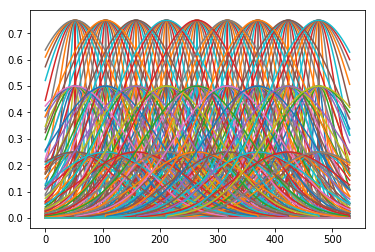

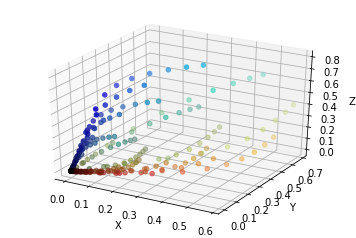

In [24]:
betas = genbetas(n,10,4,numpy.arange(1,100,10),True)
Plotmult(betas,light_D65,ref_2)

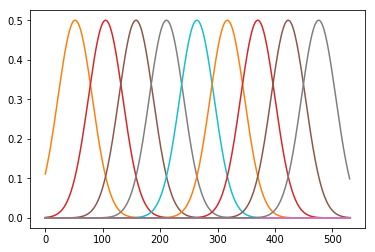

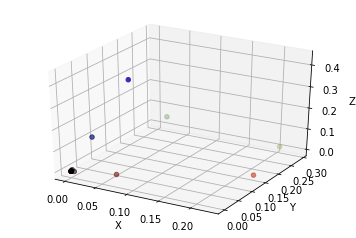

In [25]:
Plotmult(genbetas(531,10,2,[30],True),light_D65,ref_2)

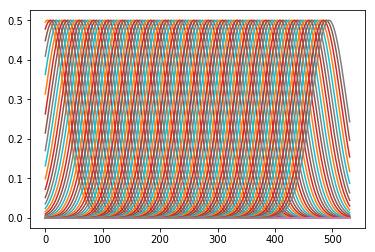

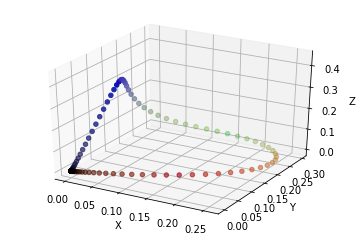

In [26]:
Plotmult(genbetas(n,100,2,[30],True),light_D65,ref_2)

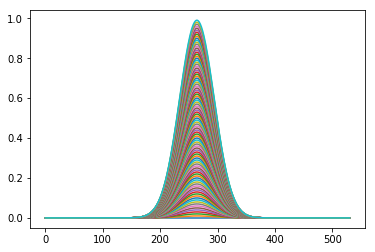

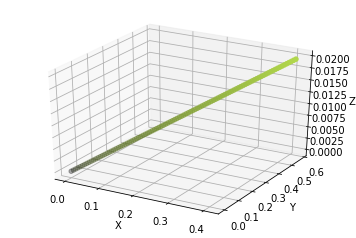

In [27]:
Plotmult(genbetas(n,2,100,[30],True),light_D65,ref_2)

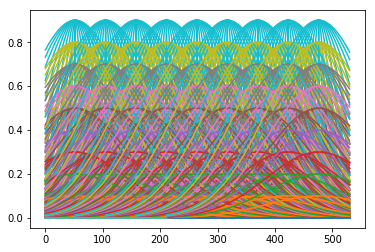

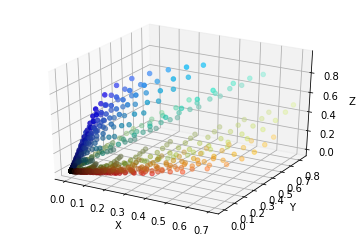

In [28]:
Plotmult(genbetas(n,10,10,numpy.arange(1,100,10),True),light_D65,ref_2)

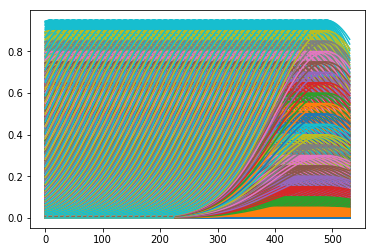

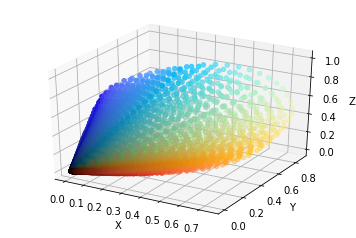

In [29]:
Plotmult(genbetas(n,50,20,numpy.arange(1,100,10),True),light_D65,ref_2)

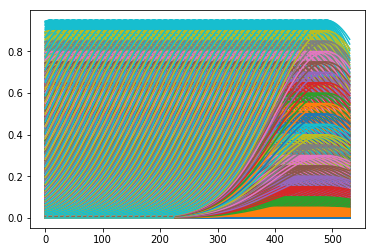

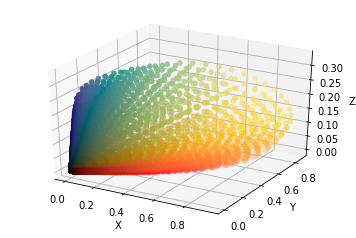

In [30]:
Plotmult(genbetas(n,50,20,numpy.arange(1,100,10),True),light_A,ref_2)

In [31]:
def PlotmultLab(betas,light,ref):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    px = []
    py = []
    pz = []
    rgb = []
    for b in betas:
        pp = CIELab(b,light,ref)
        px += [pp[0]]
        py += [pp[1]]
        pz += [pp[2]]
        rgb += [tuple(sRGBclip(CIEXYZ(b,light,ref)))]
    ax.set_xlabel('L')
    ax.set_ylabel('a')
    ax.set_zlabel('b')
    ax.scatter(px, py, pz,facecolors=rgb)

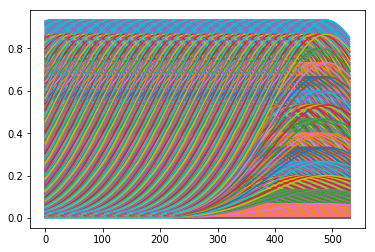

In [32]:
Labbetas = genbetas(n,50,15,numpy.arange(1,100,5),True)

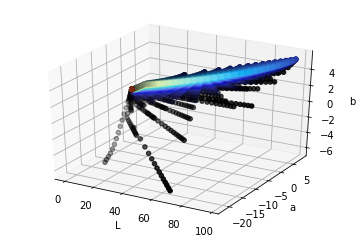

In [33]:
PlotmultLab(Labbetas,light_D65,ref_2)

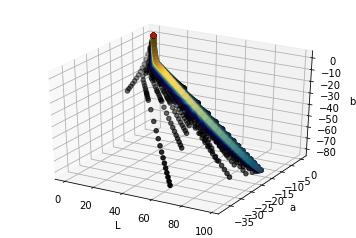

In [34]:
PlotmultLab(Labbetas,light_A,ref_2)

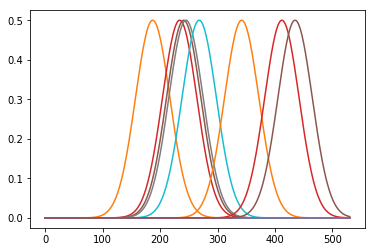

In [35]:
# mudando de impulsos distribuidos uniformemente para distribuidos normalmente

def genbetas2(N,num,dim,deviation,noise,debug=False):
    betas = []
    for dev in deviation:
        gauss = signal.gaussian(N, std=dev)
        ns = numpy.random.normal(N/2, noise, 8)
        #plt.plot(ns)
        ns.sort()
        #plt.plot(ns)
        #plt.show()
        ds = numpy.arange(0,1,1./dim)
        for n in ns:
            for d in ds:
                impulse = signal.unit_impulse(N,math.floor(n))*d
                betas += [ signal.convolve(gauss,impulse,mode='same') ] 
    if debug:
        for b in betas:
            plt.plot(b)
        plt.show()
    return betas
aaa = genbetas2(531,8,2,[30],531/6,True)

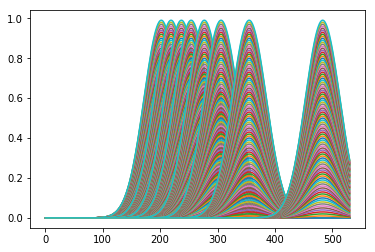

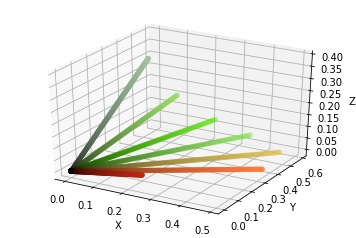

In [37]:
Plotmult(genbetas2(n,2,100,[30],531/4,True),light_D65,ref_2)

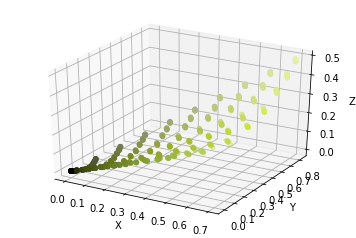

In [38]:
Plotmult(genbetas2(n,10,10,numpy.arange(1,100,10),True),light_D65,ref_2)

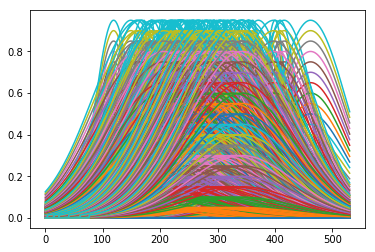

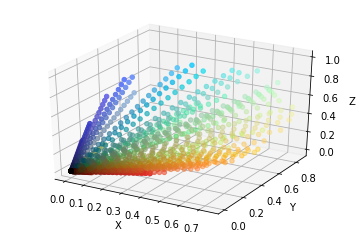

In [39]:
Plotmult(genbetas2(n,50,20,numpy.arange(1,100,10),531/8,True),light_D65,ref_2)

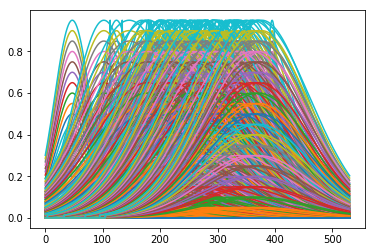

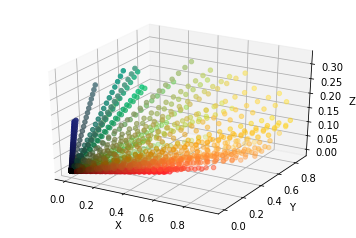

In [41]:
Plotmult(genbetas2(n,50,20,numpy.arange(1,100,10),531/8,True),light_A,ref_2)

### Envolvi tudo até agora em uma classe para otimizar um pouco memória e processamento e ficar mais confortável para programar

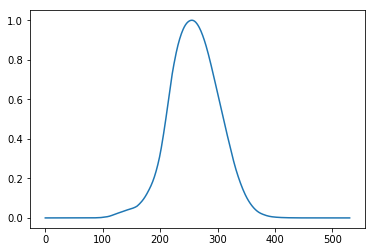

[[0.508900689417438, 0.7273855602265707, 0.09639675640066976], [0.5240673047899106, 0.6860196561897953, 0.08192385085527303]]
[[88.32287513162045, -43.6593750487107, 90.7287403199292], [86.30656637433691, -30.63452752110729, 91.54543880416593]]
[[0.7239935667814867, 0.9430611557698726, 0.14362684164570613], [0.7994333044104746, 0.8974745543892403, 0.16876354453058404]]
[[0.7239935667814867, 0.9430611557698726, 0.14362684164570613], [0.7994333044104746, 0.8974745543892403, 0.16876354453058404]]


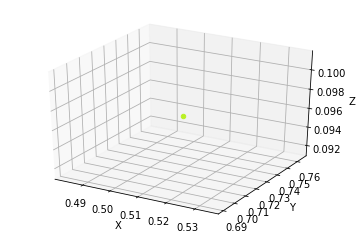

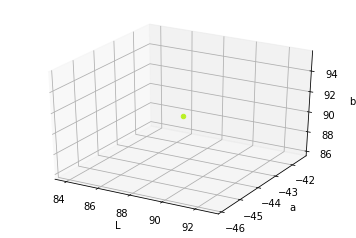

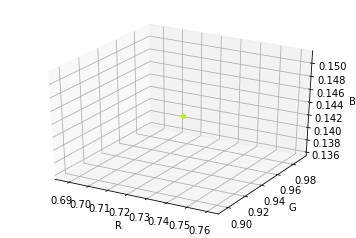

In [55]:
class color():
    
    def plotXYZ(self,ref):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pp = self.XYZ[ref]
        rgb = numpy.array([self.sRGB[ref]])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.scatter([pp[0]], [pp[1]], [pp[2]], c=rgb)
    
    def plotLab(self,ref):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pp = self.Lab[ref]
        rgb = numpy.array([self.sRGB[ref]])
        ax.set_xlabel('L')
        ax.set_ylabel('a')
        ax.set_zlabel('b')
        ax.scatter([pp[0]], [pp[1]], [pp[2]], c=rgb)
    
    def plotRGB(self,ref):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pp = self.sRGB[ref]
        rgb = numpy.array([self.sRGB[ref]])
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        ax.scatter([pp[0]], [pp[1]], [pp[2]], c=rgb)
        
    def __init__(self,spectrum,lights,debug=None):
        self.spectrum = spectrum
        self.illuminants = lights
        self.XYZ = []
        self.Lab = []
        self.sRGB = []
        self.sRGBclip = []
        i = 0
        for light in self.illuminants:
            whites = [ WhiteXYZ(light,ref_2), WhiteXYZ(light,ref_10) ]
            self.XYZ +=  [ CIEXYZ(self.spectrum,light,ref_2), CIEXYZ(self.spectrum,light,ref_10) ] 
            self.Lab += [CIELab(self.XYZ[i+0],light,ref_2,whites[0]),CIELab(self.XYZ[i+1],light,ref_10,whites[1])]
            self.sRGB += [sRGB(self.XYZ[i+0],i),sRGB(self.XYZ[i+1],i)]
            self.sRGBclip += [sRGBclip(self.XYZ[i+0],self.sRGB[i+0],i),sRGBclip(self.XYZ[i+1],self.sRGB[i+1],i)]
            i = i + 1
        if debug:
            plt.plot(self.spectrum)
            plt.show()
            print(self.XYZ)
            print(self.Lab)
            print(self.sRGB)
            print(self.sRGBclip)
            self.plotXYZ(0)
            self.plotLab(0)
            self.plotRGB(0)
color(mat,[light_D65],True)

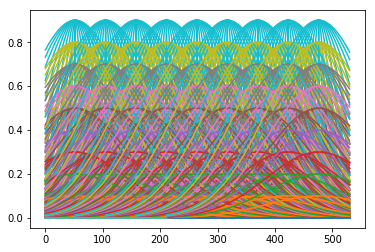

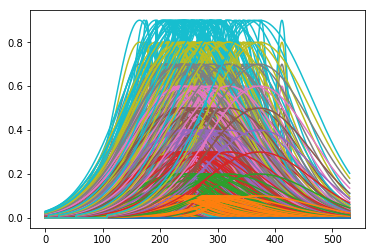

In [44]:
genbetas(531,10,10,numpy.arange(1,100,10),True)
betas = genbetas2(531,10,10,numpy.arange(1,100,10),531/10,True)

In [56]:
colors = [color(beta,[light_D65]) for beta in betas]        

# Respostas

442
443
444
445
446
447


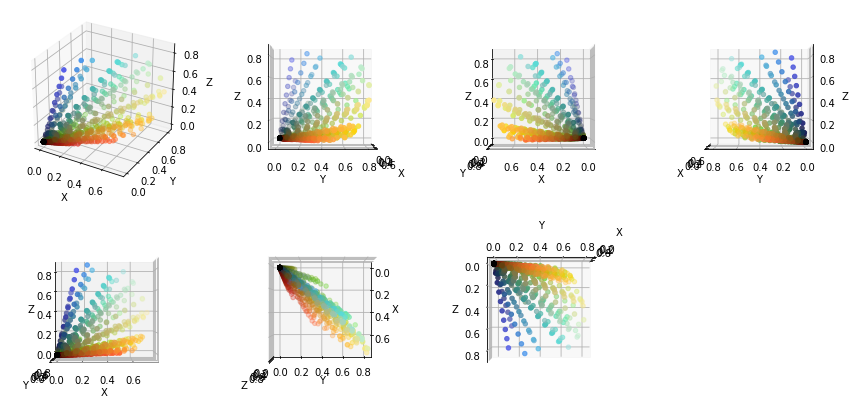

In [155]:
def PlotcolorsXYZ(colors,ref,views):
    fig = plt.figure(figsize = (15,15))
    px = []
    py = []
    pz = []
    rgb = []
    for c in colors:
        pp = c.XYZ[ref]
        px += [pp[0]]
        py += [pp[1]]
        pz += [pp[2]]
        rgb += [tuple(c.sRGBclip[ref])]
    ax = fig.add_subplot(int(str(len(views)//2+1)*2+'1'), projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(px, py, pz,facecolors=rgb) 
    for view in views:
        index = int(str(len(views)//2+1)*2+str(views.index(view)+2))
        print(index)
        ax = fig.add_subplot(index, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.scatter(px, py, pz,facecolors=rgb) 
        ax.view_init(elev=view[0],azim=view[1])
    #fig.show()
    
PlotcolorsXYZ(colors,0,[[0,0],[0,90],[0,180],[0,270],[90,0],[180,0]])

442
443
444
445
446
447


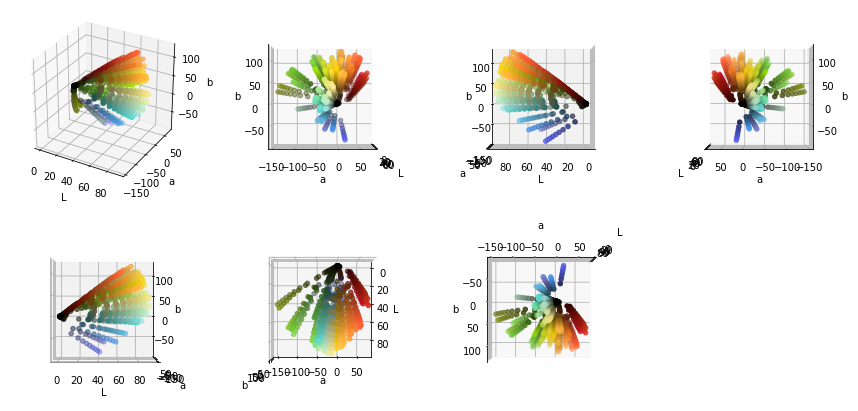

In [159]:
def PlotcolorsLab(colors,ref,views):
    fig = plt.figure(figsize = (15,15))
    px = []
    py = []
    pz = []
    rgb = []
    for c in colors:
        pp = c.Lab[ref]
        px += [pp[0]]
        py += [pp[1]]
        pz += [pp[2]]
        rgb += [tuple(c.sRGBclip[ref])]
        
    ax = fig.add_subplot(int(str(len(views)//2+1)*2+'1'), projection='3d')
    ax.set_xlabel('L')
    ax.set_ylabel('a')
    ax.set_zlabel('b')
    ax.scatter(px, py, pz,facecolors=rgb) 
    for view in views:
        index = int(str(len(views)//2+1)*2+str(views.index(view)+2))
        print(index)
        ax = fig.add_subplot(index, projection='3d')
        ax.set_xlabel('L')
        ax.set_ylabel('a')
        ax.set_zlabel('b')
        ax.scatter(px, py, pz,facecolors=rgb) 
        ax.view_init(elev=view[0],azim=view[1])
        
PlotcolorsLab(colors,0,[[0,0],[0,90],[0,180],[0,270],[90,0],[180,0]])

442
443
444
445
446
447


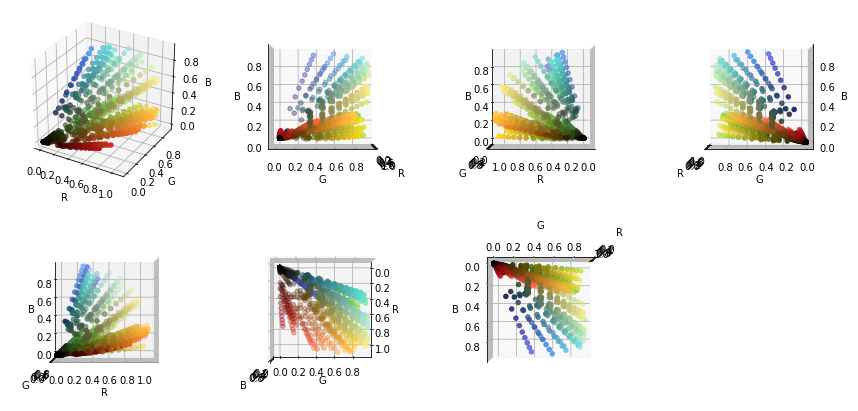

In [164]:
def PlotcolorsRGB(colors,ref,views):
    fig = plt.figure(figsize = (15,15))
    px = []
    py = []
    pz = []
    rgb = []
    for c in colors:
        pp = c.sRGB[ref]
        px += [pp[0]]
        py += [pp[1]]
        pz += [pp[2]]
        rgb += [tuple(c.sRGBclip[ref])]
    ax = fig.add_subplot(int(str(len(views)//2+1)*2+'1'), projection='3d')
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.scatter(px, py, pz,facecolors=rgb)
    for view in views:
        index = int(str(len(views)//2+1)*2+str(views.index(view)+2))
        print(index)
        ax = fig.add_subplot(index, projection='3d')
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        ax.scatter(px, py, pz,facecolors=rgb) 
        ax.view_init(elev=view[0],azim=view[1])
    
PlotcolorsRGB(colors,0,[[0,0],[0,90],[0,180],[0,270],[90,0],[180,0]])

### Por fim, fazer o caminho inverso: de sRGB para XYZ

442
443
444
445
446
447


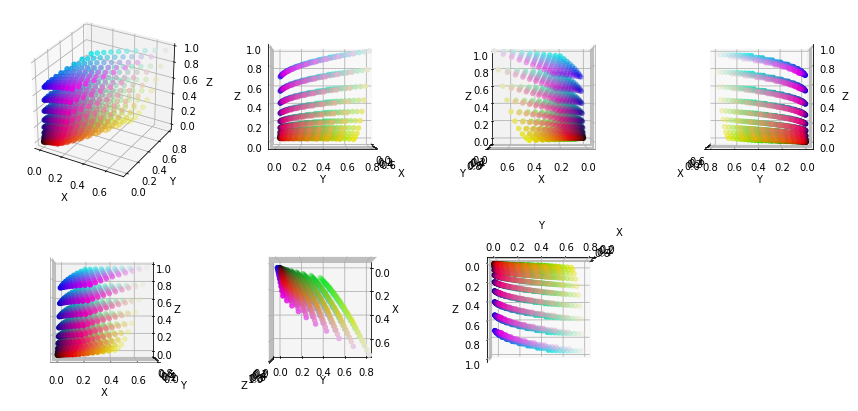

In [162]:
def Icompand(v):
    v = abs(v)
    if v <= 0.04045 :
        return v / 12.92
    else:
        return ((v + 0.055)/(1.055))**(2.4)



def sRGB_XYZ(color,ilu=0):
    # Matriz de conversão RGB -> XYZ em D65. Retirada do site do Lindbloom.
    sRGBref_D65 = [[ 0.4124564, 0.3575761, 0.1804375],
           [  0.2126729,  0.7151522,  0.0721750],
           [  0.0193339,  0.1191920,  0.9503041]]
    # Matriz de conversão RGB -> XYZ em D50. Retirada do site do Lindbloom.
    sRGBref_D50 = [[0.4360747,  0.3850649,  0.1430804],
             [0.2225045,  0.7168786,  0.0606169],
             [0.0139322,  0.0971045,  0.7141733]]
    sRGBref = [sRGBref_D65,sRGBref_D50]
    _xyz = numpy.dot(sRGBref[ilu],color)
    _xyz = [ Icompand(i) for i in _xyz]
    return _xyz

a = numpy.arange(0,1,0.1)
b = numpy.arange(0,1,0.1)
c = numpy.arange(0,1,0.1)
nums = []
for i in a:
    for j in b:
        for k in c:
            nums += [[i,j,k]]
#print(nums)

#nums = genbetas2(3,8,8,numpy.arange(1,100,10),0.1,True)
#print(nums)

def PlotRGB(nums,ilu=0,views=[[0,0]]):
    fig = plt.figure(figsize = (15,15))
    px = []
    py = []
    pz = []
    rgb = []
    for n in nums:
        pp = sRGB_XYZ(n,0)
        px += [pp[0]]
        py += [pp[1]]
        pz += [pp[2]]
        rgb += [tuple(n)]
    ax = fig.add_subplot(int(str(len(views)//2+1)*2+'1'), projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(px, py, pz,facecolors=rgb)
    for view in views:
        index = int(str(len(views)//2+1)*2+str(views.index(view)+2))
        print(index)
        ax = fig.add_subplot(index, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.scatter(px, py, pz,facecolors=rgb) 
        ax.view_init(elev=view[0],azim=view[1])
    
PlotRGB(nums,0,[[0,0],[0,90],[0,180],[0,270],[90,0],[180,0]])

In [119]:
betas_exercicio = [coluna_D,coluna_F,coluna_G,coluna_H]
cores = [color(beta,[light_D65]) for beta in betas_exercicio]        
dados = {'coluna': ['D','F','G','H'], 
         'XYZ': ['X: %f Y:%f Z:%f'% tuple(v.XYZ[0]) for v in cores],
         'Lab': ['L: %f a:%f b:%f'% tuple(v.Lab[0]) for v in cores],
         'sRGB': ['R: %f G:%f B:%f'% tuple(v.sRGB[0]) for v in cores],
         'exemplo':["#%2x%2x%2x"%(tuple([int(255*i) for i in v.sRGBclip[0]])) for v in cores]}
tabela = pandas.DataFrame(data=dados)
tabela = tabela[['coluna','XYZ','Lab','sRGB','exemplo']]

def style(v):
    return 'background-color: '+ v
styled = tabela.style.applymap(style,
                  subset=pandas.IndexSlice[['exemplo']])
styled 